In [1]:
# only adjust settings in this cell
state = 'KS' 
year = 2020
enumeration_limit = 10

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of KS has 4 districts.


In [5]:
from optimization import generate_plans_with_refinement

plans, first_feasible_dev = generate_plans_with_refinement(G, ideal_population, state, year, enumeration_limit)


*****************************************
Trying deviation = 0.5.
*****************************************
Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-01
Total time = 4257.45

*****************************************
Trying deviation = 1.0.
*****************************************
Total time = 2864.05

*****************************************
Trying deviation = 2.0.
*****************************************
Total time = 2265.18

*****************************************
Trying deviation = 4.0.
*****************************************
Total time = 1698.35

*****************************************
Trying deviation = 8.0.
*****************************************
Total time = 4609.9

*****************************************
Trying deviation = 16.0.
*****************************************
Total time = 3379.92

*****************************************
Trying deviation = 32.0.
*****************************************
Total time = 2450.7

In [6]:
no_solution_region = [0, first_feasible_dev] if first_feasible_dev > 0.5 else None
print(f"No feasible solution was found within the region: {no_solution_region}")

No feasible solution was found within the region: [0, 4.0]


***************************************
obj_type = cut_edges
***************************************
Pareto front objective values: [[4.0, 76], [7.0, 64], [8.0, 51], [53.0, 50], [81.0, 48], [150.0, 44], [235.0, 43], [282.0, 42], [295.0, 41], [315.0, 38], [937.0, 37], [1059.0, 35], [2464.0, 34], [3237.0, 33], [4115.0, 32]]


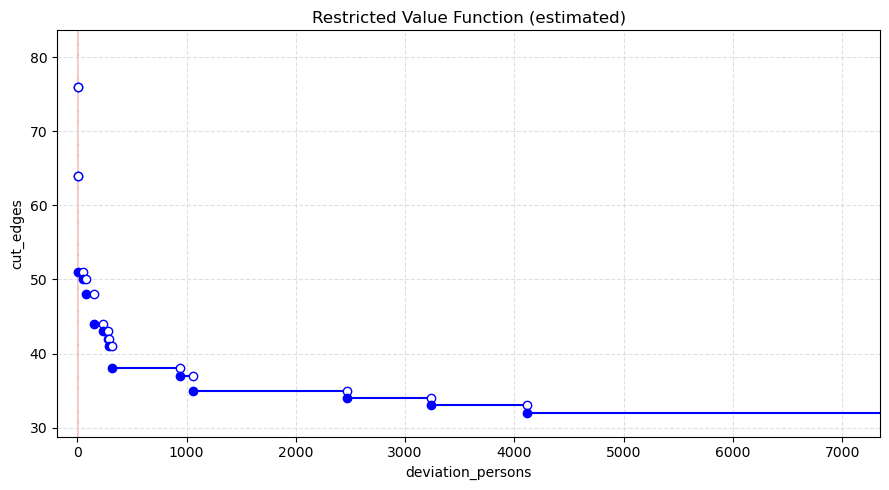

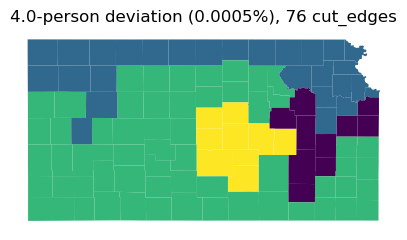

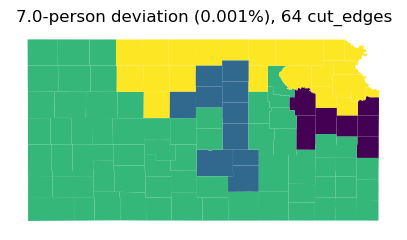

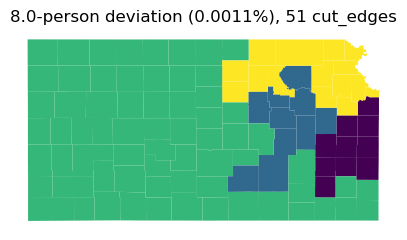

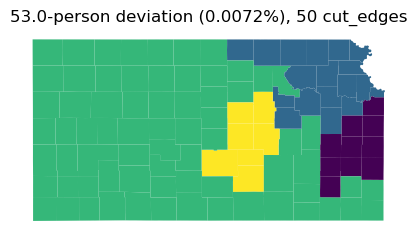

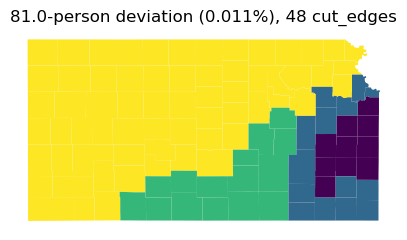

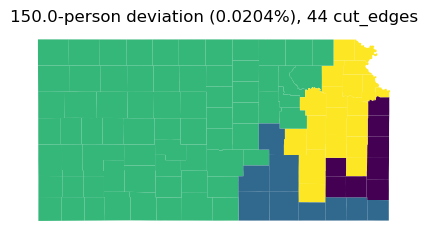

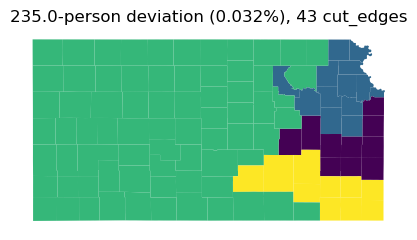

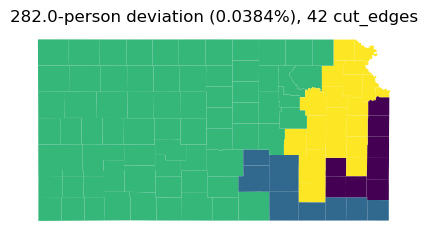

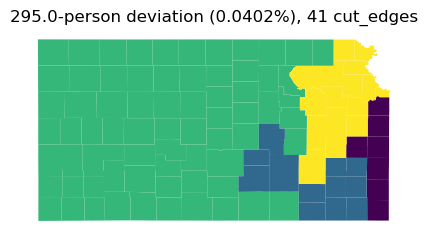

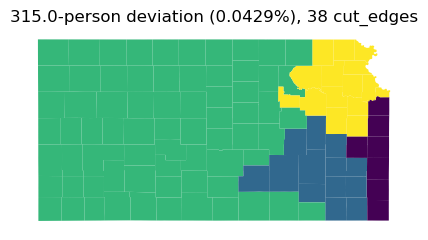

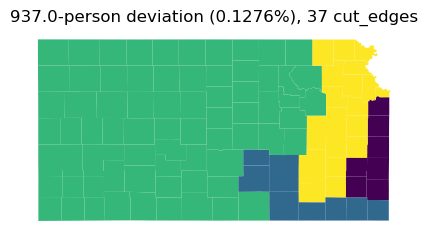

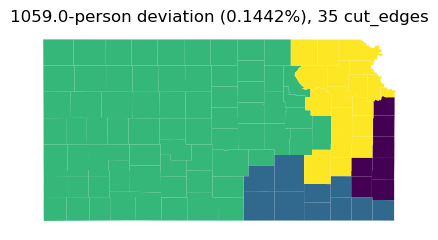

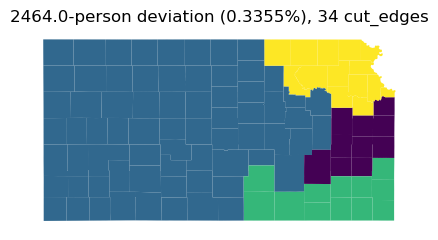

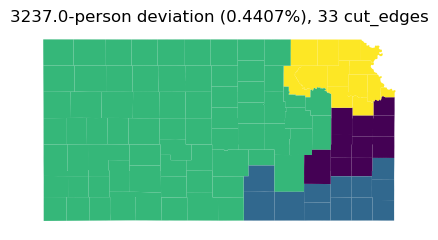

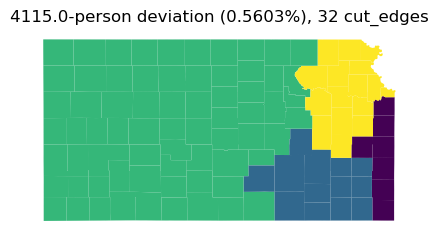

***************************************
obj_type = perimeter
***************************************
Pareto front objective values: [[4.0, 68.38522320674049], [5.0, 67.95823324424717], [7.0, 61.016468780018755], [8.0, 53.56455353648915], [27.0, 52.847541874854976], [32.0, 52.49411678955266], [46.0, 51.68205412440069], [81.0, 50.38657935925994], [97.0, 50.365479871287036], [150.0, 47.12073714591785], [282.0, 46.509660449543716], [295.0, 45.90598553224105], [383.0, 45.51909963784082], [494.0, 45.36325761077165], [504.0, 42.99954930834638], [937.0, 42.99358271107732], [1105.0, 41.84190786300035], [4190.0, 41.30982850428849], [5439.0, 41.09627559902399], [5822.0, 39.847545950913265]]


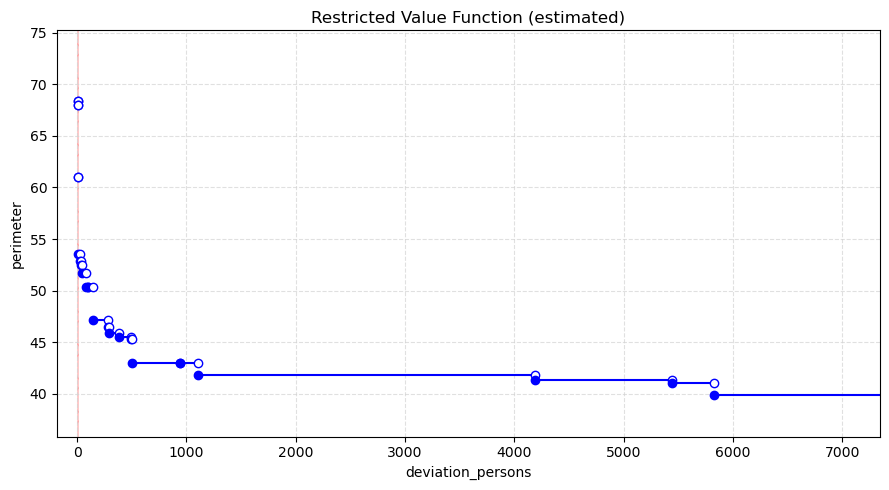

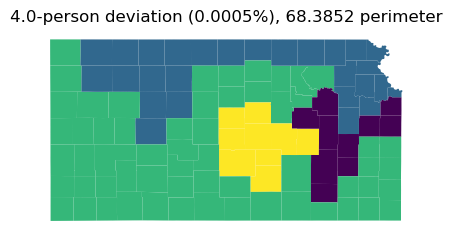

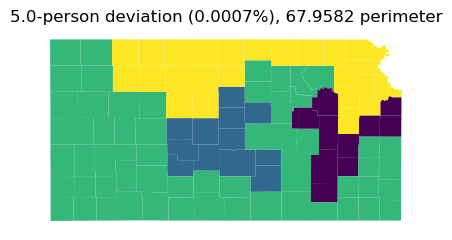

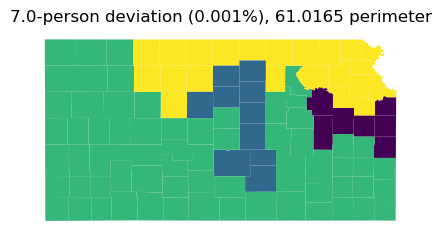

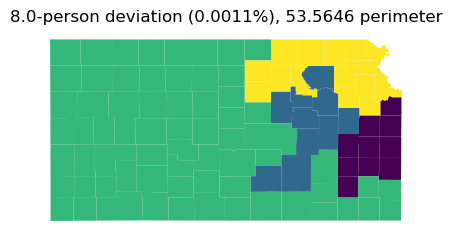

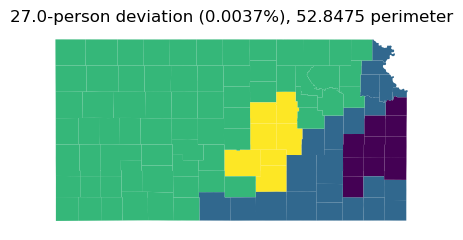

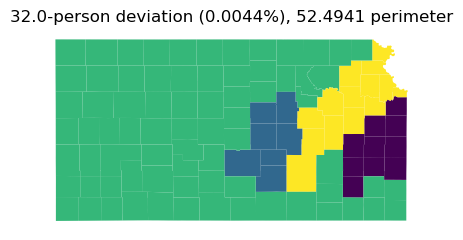

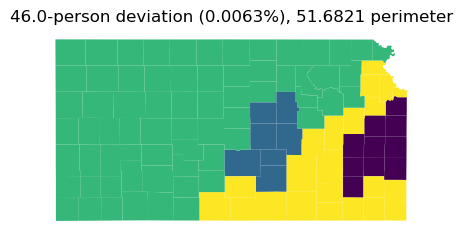

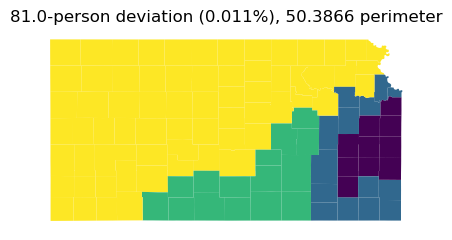

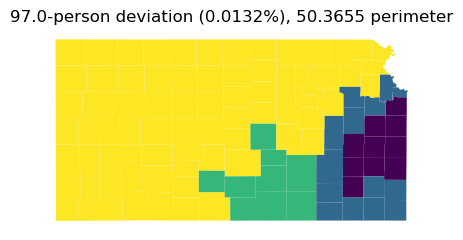

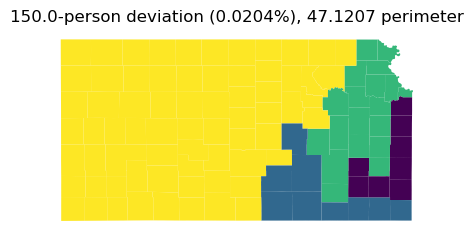

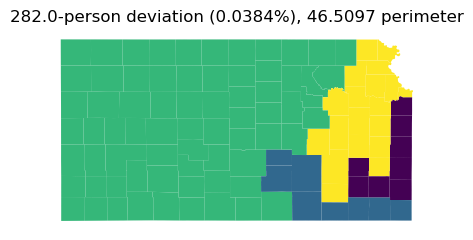

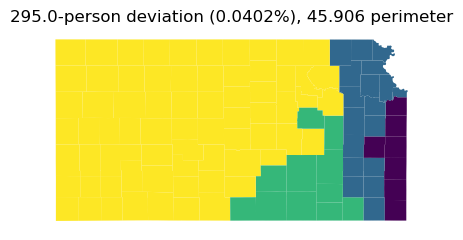

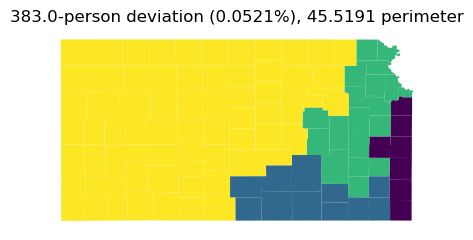

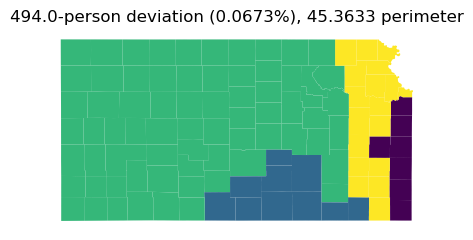

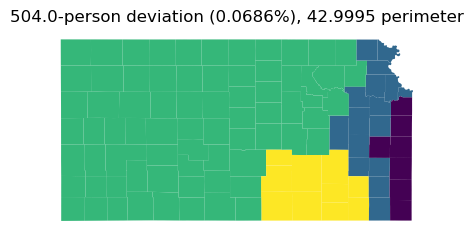

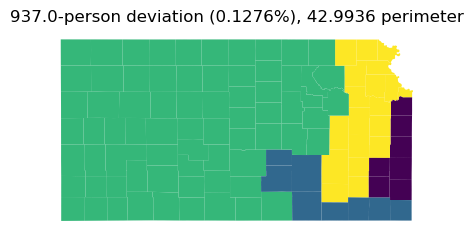

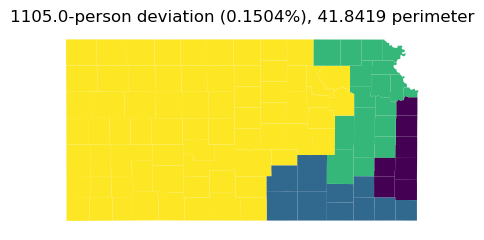

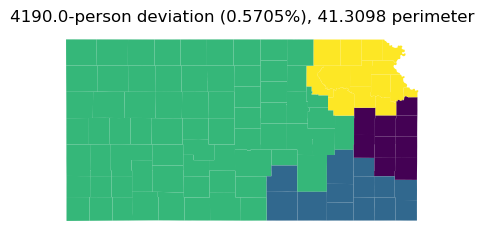

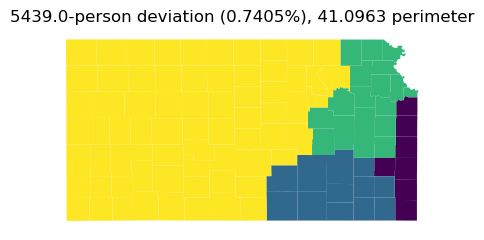

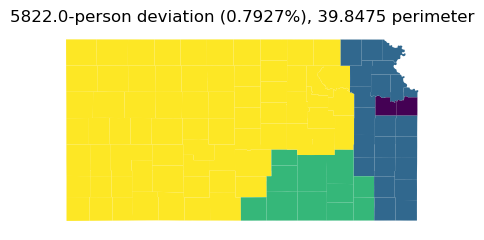

***************************************
obj_type = inverse_Polsby_Popper
***************************************
Pareto front objective values: [[4.0, 4.676242457424785], [5.0, 4.629658994211127], [7.0, 4.034614919592191], [8.0, 3.277869785914562], [10.0, 3.2296823017692553], [11.0, 3.1602638021257228], [21.0, 3.137438438274912], [22.0, 3.049612246003658], [38.0, 3.0467446883880775], [124.0, 3.0190333798739406], [167.0, 2.9941488132211056], [224.0, 2.7791069078960327], [235.0, 2.66599430656135], [368.0, 2.6311046460146237], [900.0, 2.568482312004412], [937.0, 2.4296627320310877], [1105.0, 2.392628627386489], [1694.0, 2.361255287801487], [1869.0, 2.3471116613240466], [3811.0, 2.27134529907396], [4190.0, 2.1448947206516578], [7226.0, 2.1405350324816235], [7305.0, 2.13795776648982]]


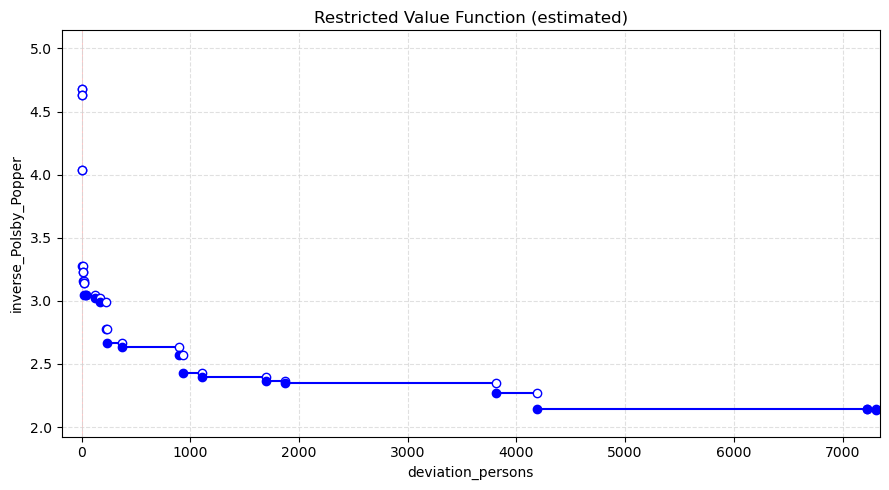

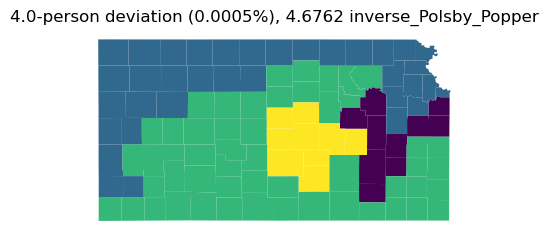

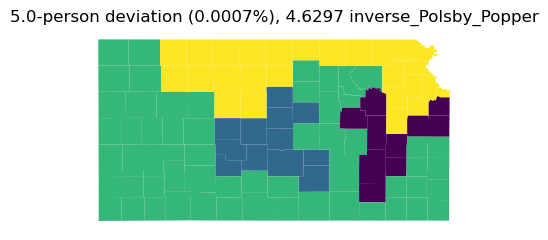

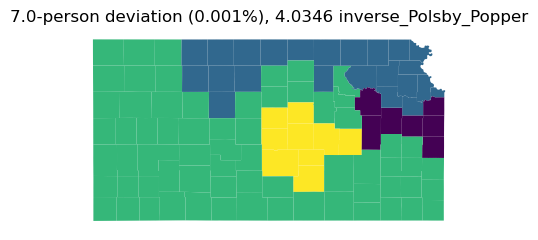

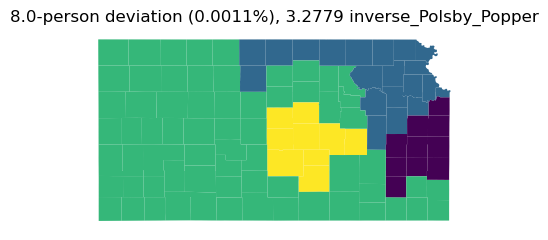

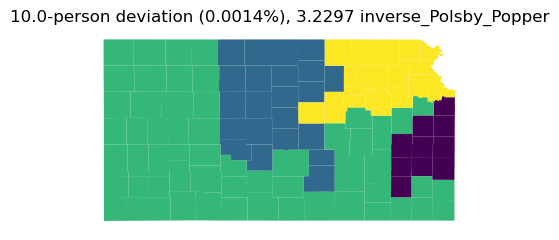

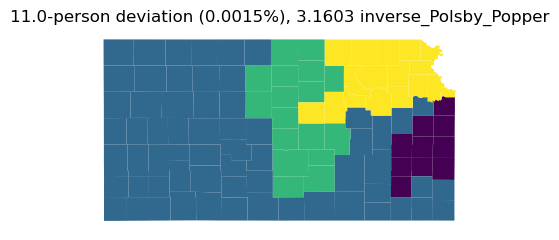

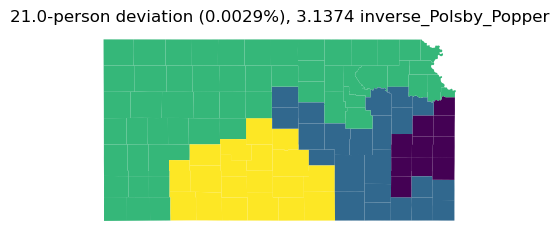

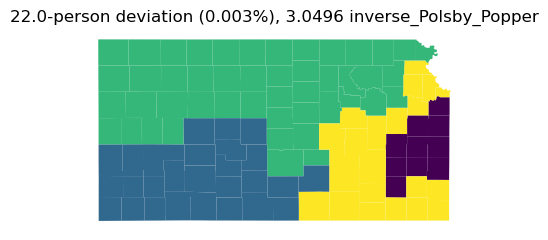

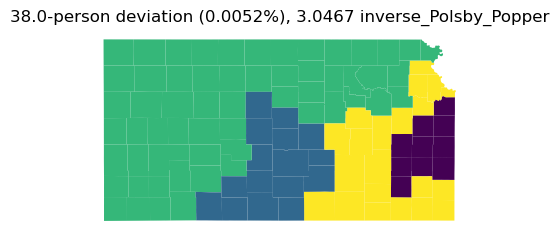

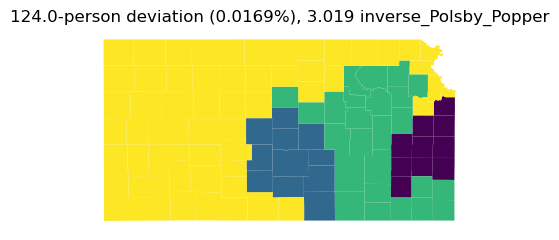

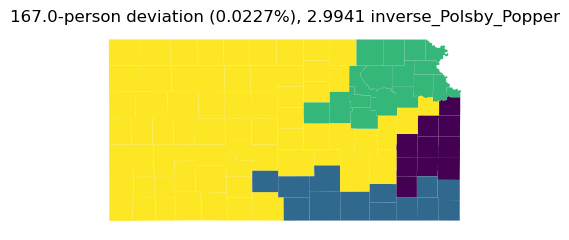

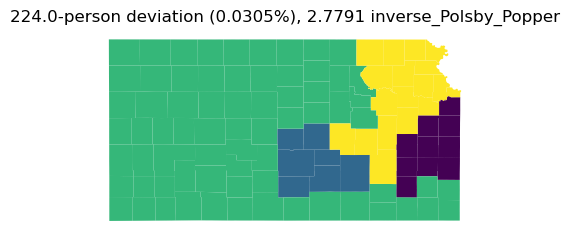

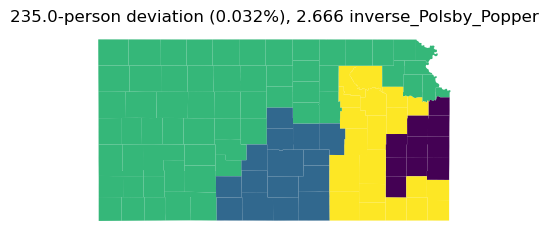

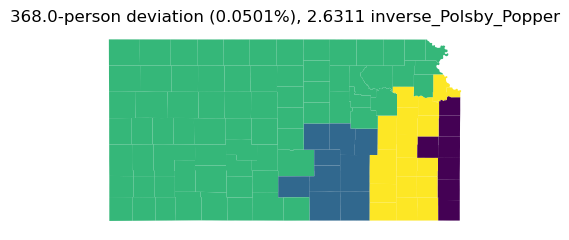

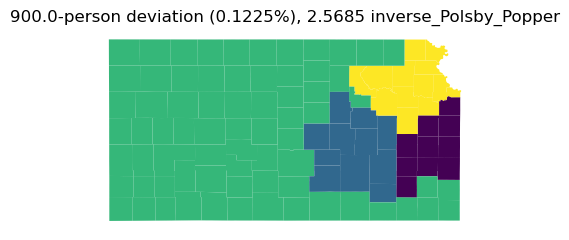

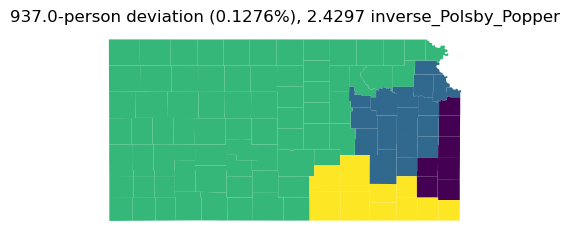

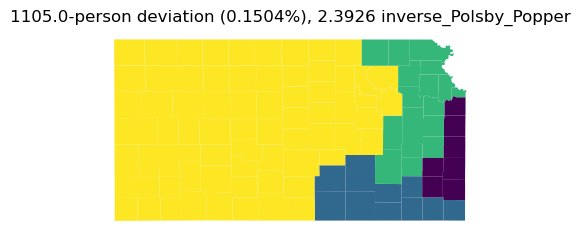

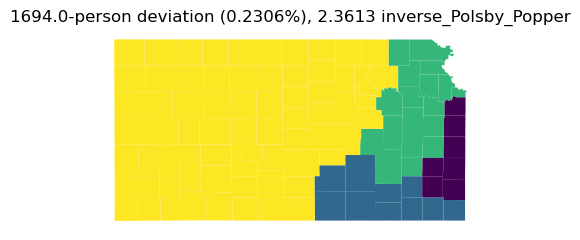

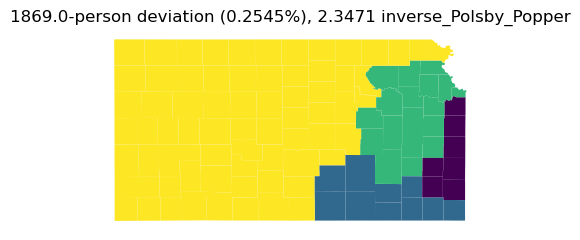

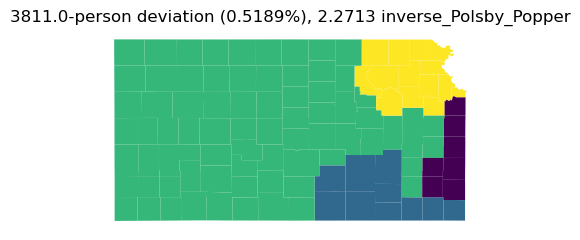

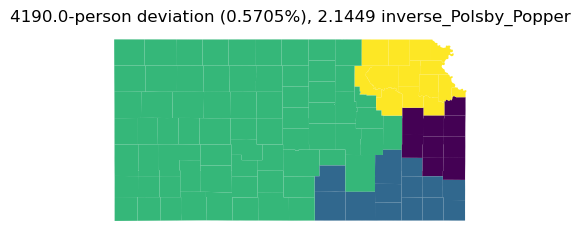

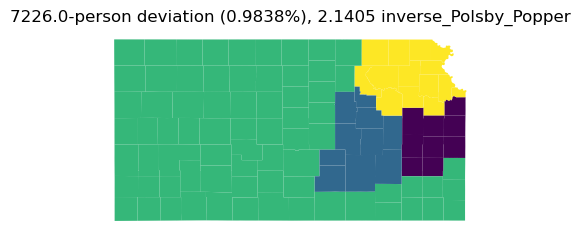

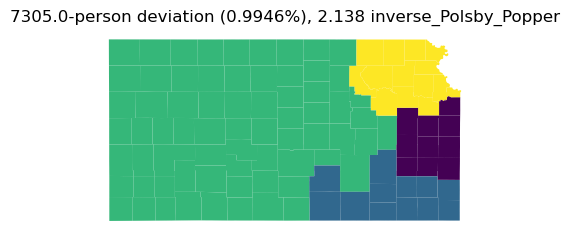

***************************************
obj_type = average_Polsby_Popper
***************************************
Pareto front objective values: [[4.0, 0.26324525384525777], [7.0, 0.28921351117650784], [8.0, 0.36827599134836797], [15.0, 0.3724224779983085], [21.0, 0.3762069526799239], [24.0, 0.3826738042107315], [211.0, 0.39548167880472646], [224.0, 0.4018754759412317], [323.0, 0.4032807883360168], [466.0, 0.41200889239859045], [504.0, 0.4411468762680403], [1105.0, 0.4459319833559545], [2385.0, 0.44805586858028057], [2431.0, 0.4540923351714673], [4019.0, 0.45806021879495556], [4190.0, 0.4764994815433573], [7226.0, 0.47794016039564935], [7305.0, 0.48437357133142717]]


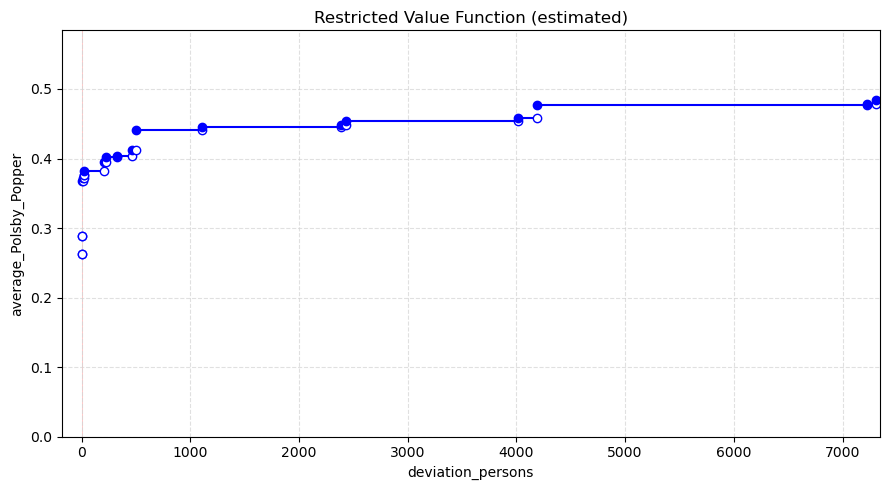

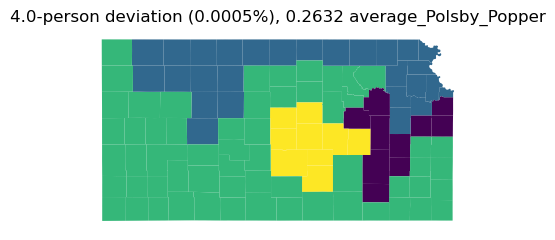

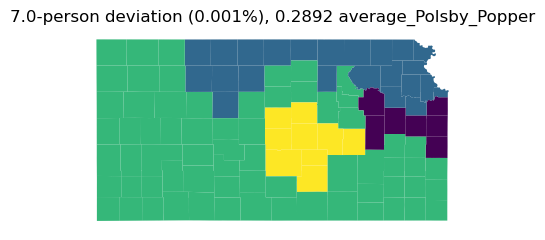

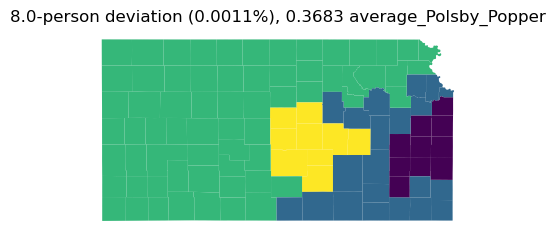

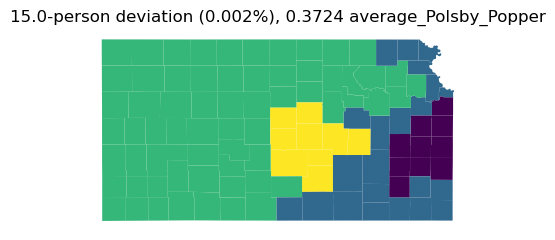

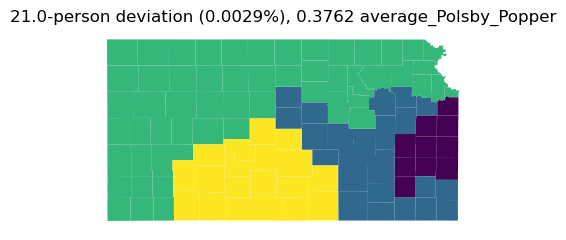

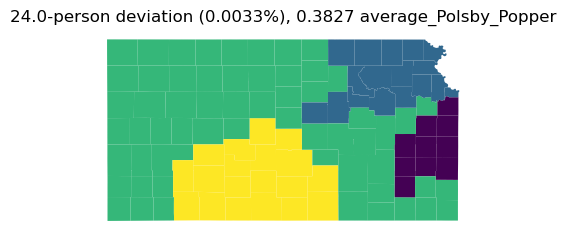

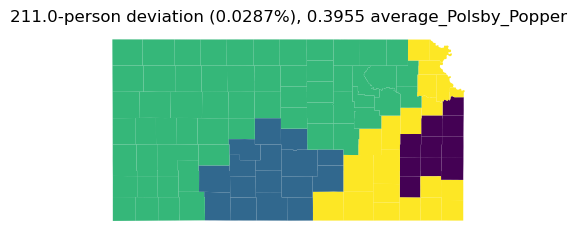

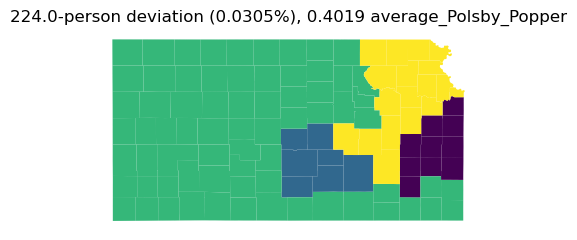

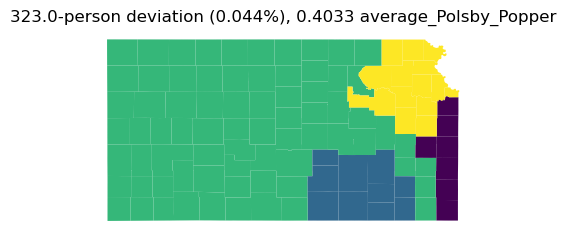

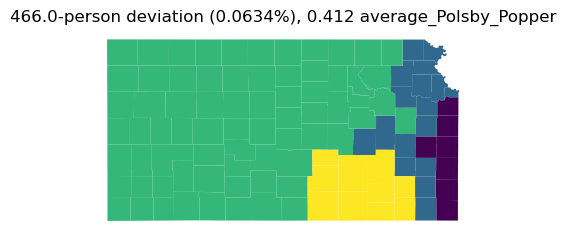

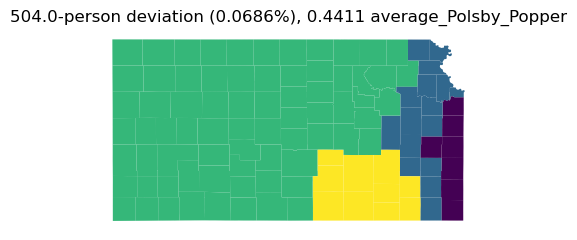

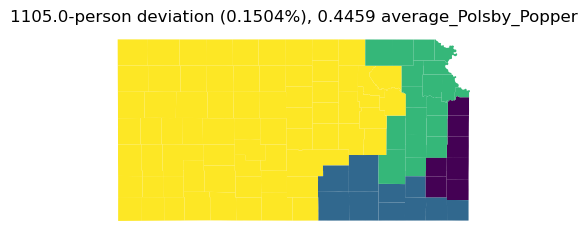

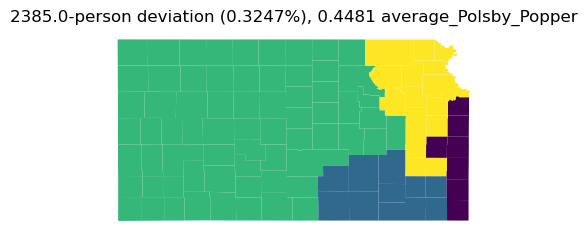

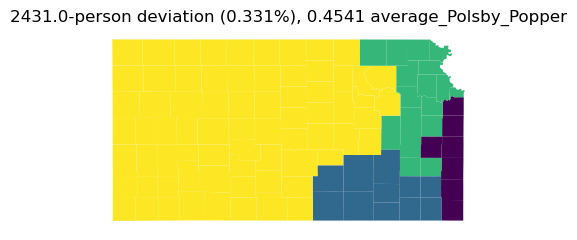

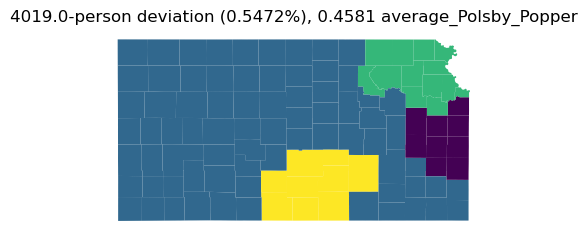

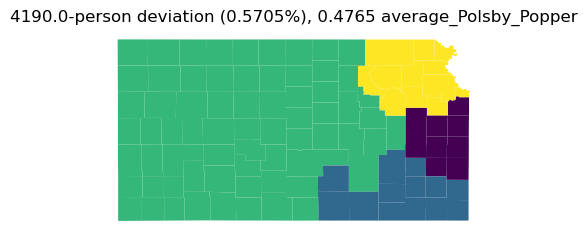

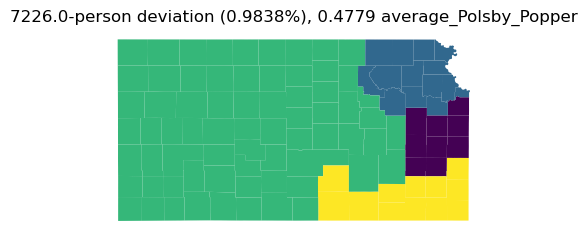

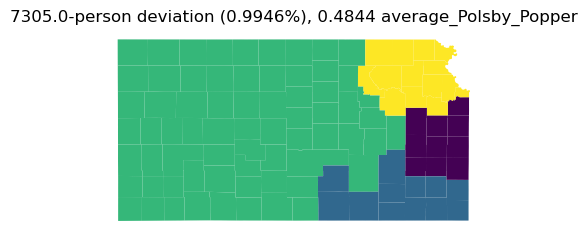

***************************************
obj_type = bottleneck_Polsby_Popper
***************************************
Pareto front objective values: [[4.0, 0.1592434535184309], [5.0, 0.1705326740884489], [7.0, 0.20010494922961838], [8.0, 0.22869378740338384], [32.0, 0.24013055646264508], [53.0, 0.24056392599984738], [94.0, 0.24679340422354293], [150.0, 0.2776124508089337], [163.0, 0.30661022672093785], [235.0, 0.31263576362630746], [368.0, 0.32348117671654253], [412.0, 0.34518901542370445], [937.0, 0.3663492360061187], [1798.0, 0.3810935297827451], [1869.0, 0.39779942779577276], [3811.0, 0.4347169597651818], [7131.0, 0.4385492364569628]]


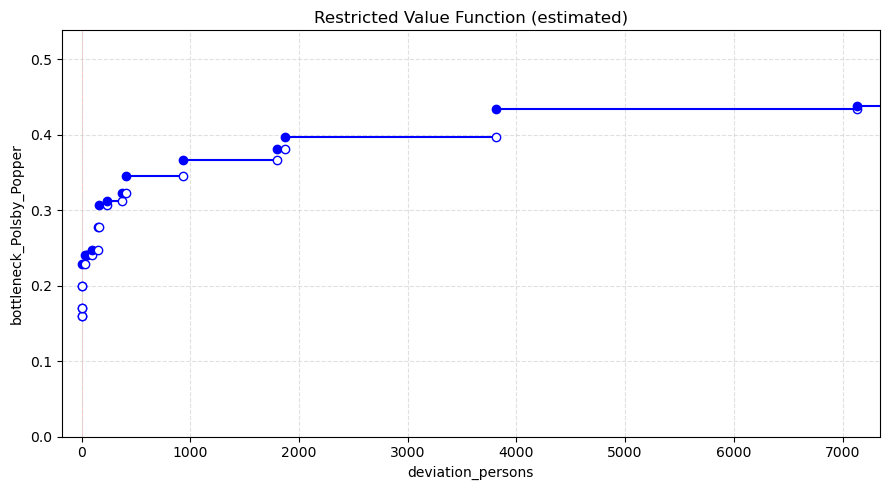

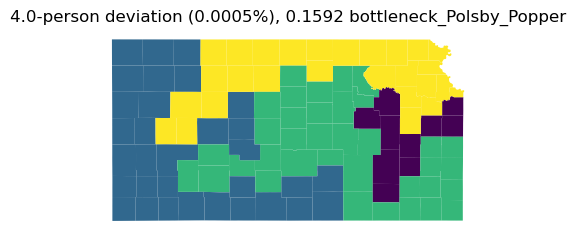

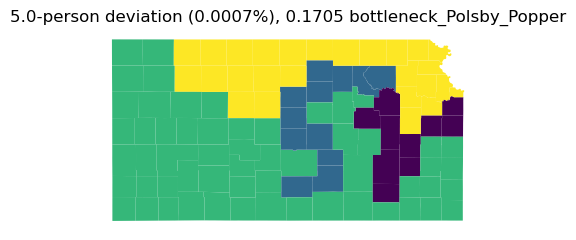

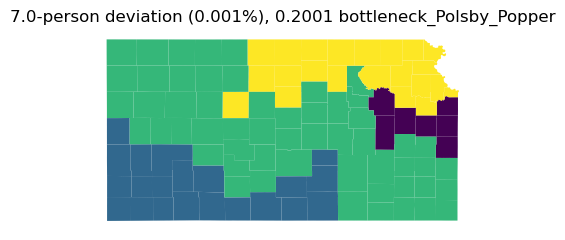

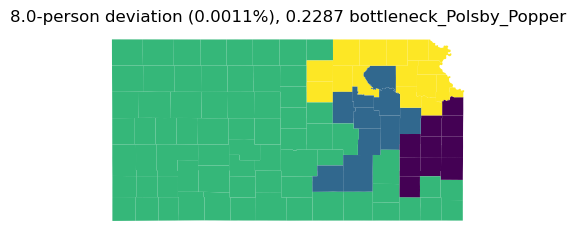

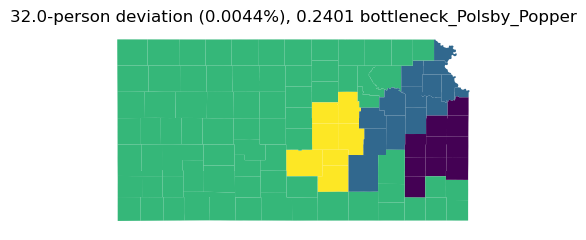

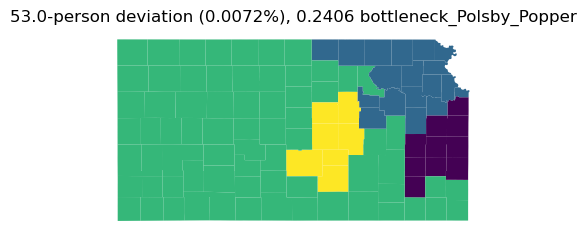

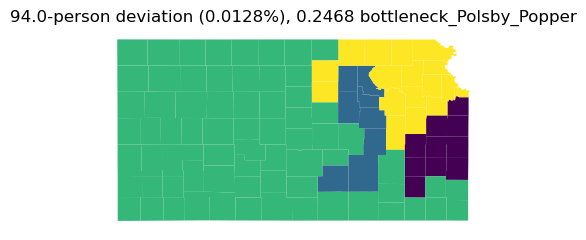

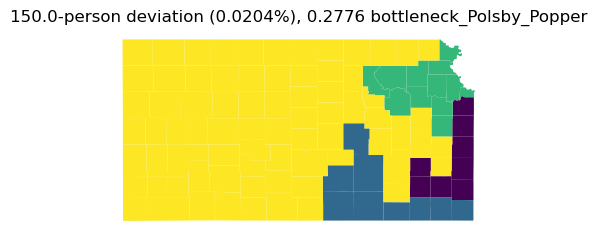

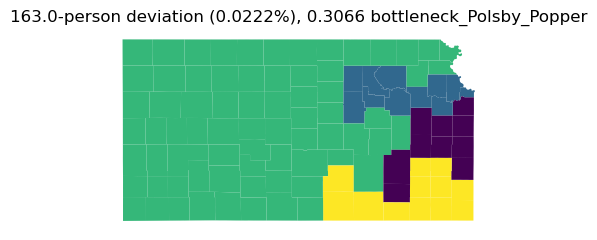

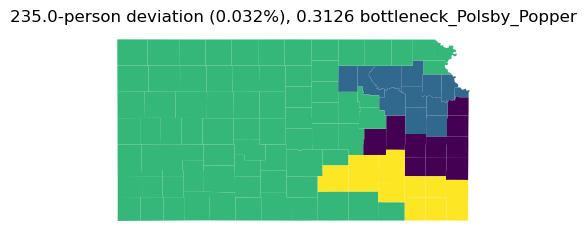

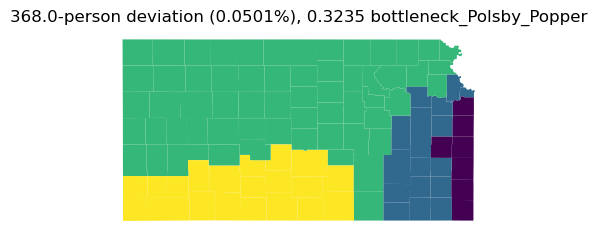

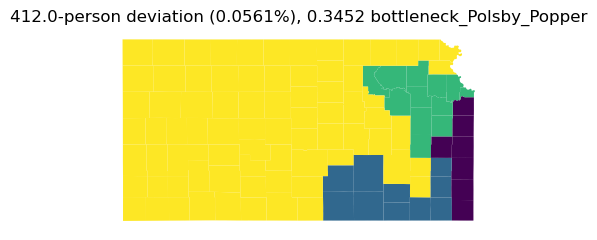

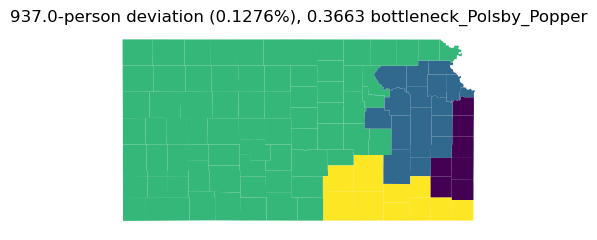

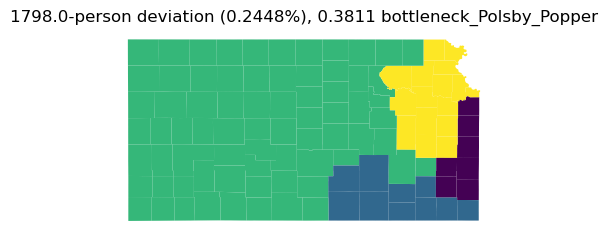

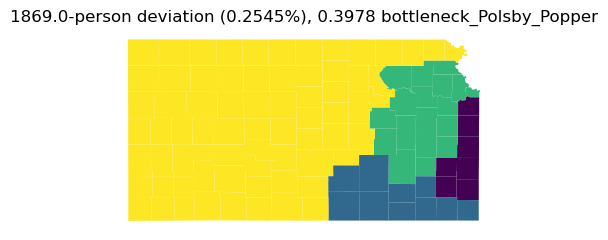

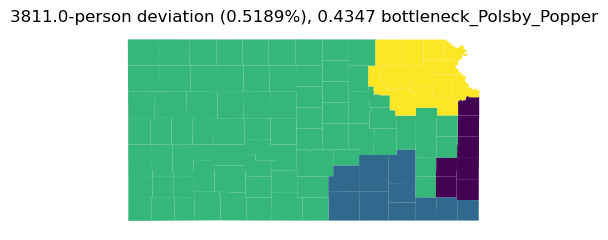

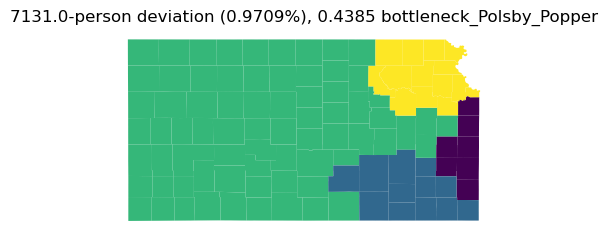

In [7]:
from pareto import plot_pareto_frontiers

obj_types = ['cut_edges', 'perimeter', 'inverse_Polsby_Popper', 'average_Polsby_Popper', 'bottleneck_Polsby_Popper']

pareto_plans = plot_pareto_frontiers(
                G,
                method='heuristic',
                plans=plans,                                   #if method ='epsilon_constraint_method' is None 
                obj_types=obj_types,                           #if method ='epsilon_constraint_method' is obj_type
                ideal_population=ideal_population,
                state=state,
                filepath=filepath,
                filename2=filename2,
                no_solution_region=no_solution_region,
                year=year,
                result=None,                                   #if method ='heuristic' is None 
             )

In [8]:
len(plans)

27687

In [9]:
for obj_type in obj_types:
    print("***************************************")
    print("obj_type =", obj_type)
    print("***************************************")
    print("Pareto front plans:", pareto_plans[obj_type])

***************************************
obj_type = cut_edges
***************************************
Pareto front plans: [[[5, 11, 13, 21, 28, 42, 45, 62, 65, 76], [6, 10, 12, 15, 18, 24, 27, 29, 30, 31, 37, 41, 46, 47, 58, 61, 63, 64, 70, 77, 78, 79, 89, 92, 95, 97, 103], [0, 1, 2, 3, 7, 8, 14, 16, 17, 19, 22, 23, 25, 34, 35, 36, 38, 39, 40, 43, 44, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 67, 68, 69, 71, 72, 73, 74, 75, 80, 81, 82, 83, 84, 85, 87, 88, 90, 91, 93, 94, 96, 98, 99, 100, 101, 102, 104], [4, 9, 20, 26, 32, 33, 48, 66, 86]], [[5, 11, 13, 14, 21, 28, 30], [9, 20, 25, 26, 32, 33, 40, 93, 94, 96], [0, 1, 2, 3, 4, 7, 16, 17, 19, 22, 23, 34, 35, 36, 38, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 97, 98, 99, 100, 102, 103, 104], [6, 8, 10, 12, 15, 18, 24, 27, 29, 31, 37, 39, 41, 51, 61, 63, 64, 70, 74, 77, 79, 95, 101]], [[11, 13, 14, 21, 38, 45, 50